In [12]:
import sys as _sys
import os

current_path = os.path.abspath(os.getcwd())

split = current_path.split("sgi_igl")
if len(split)<2:
    print("Please rename the repository 'sgi_igl'")
    raise ValueError
path_to_python_scripts = os.path.join(split[0], "sgi_igl/python/")
path_to_notifications = os.path.join(split[0], "sgi_igl/notebooks/notifications/")
path_to_settings = os.path.join(split[0], "sgi_igl/python/experiments/")
path_to_cubic_splines = os.path.join(split[0], "sgi_igl/ext/torchcubicspline/")
path_to_output = os.path.join(split[0], "sgi_igl/output/")
path_to_output_snake = os.path.join(path_to_output, "snake_all_joints/")

if not os.path.exists(path_to_output_snake):
    os.makedirs(path_to_output_snake)

_sys.path.insert(0, path_to_python_scripts)
_sys.path.insert(0, path_to_settings)
_sys.path.insert(0, path_to_cubic_splines)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

from geometry_io import export_snakes_to_json
from objectives import compare_last_translation, grad_compare_last_translation
from objectives import energy_path, grad_energy_path
from scipy.optimize import minimize, Bounds
from snake_all_joints_settings import return_snake_all_joints_experiment_settings
from snake_shapes import snake_angles_generation
from step_backward_edge import multiple_steps_backward_material_pos_
from step_forward_edge import multiple_steps_forward
from utils import axis_angle_to_quaternion, print_quaternion

TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)

# Define initial gait and material parameters

## Parameters

In [ ]:
trial_number = 1
tag_experiment = "_{:02d}".format(trial_number)

settings_dict = return_snake_all_joints_experiment_settings(trial_number)
n_points_snake, n_angles, n_ts = settings_dict["n_pts"], settings_dict["n_angles"], settings_dict["n_ts"]
edges = np.array(settings_dict["edges"])
n_edges = edges.shape[0]
rho, eps, snake_length, close_snake_gait = settings_dict['rho'], settings_dict['eps'], settings_dict['snake_length'], settings_dict['close_gait']
broken_joint_ids, broken_joint_angles = settings_dict['broken_joint_ids'], torch.tensor(settings_dict['broken_joint_angles'])
w_fit, w_energy = settings_dict['w_fit'], settings_dict['w_energy']
gt = np.array(settings_dict['gt'])
init_perturb_magnitude = settings_dict['init_perturb_magnitude']
min_turning_angle, max_turning_angle = settings_dict['min_turning_angle'], settings_dict['max_turning_angle']
maxiter = settings_dict['maxiter']

broken_joint_angles = broken_joint_angles.reshape(1, -1) * torch.ones(size=(n_ts-close_snake_gait, 1))
n_op_angles = n_angles - len(broken_joint_ids)
    
total_mass = rho * snake_length
w_fit_scaled = w_fit / (snake_length ** 2)
w_energy_scaled = w_energy / (total_mass * snake_length ** 2)

edges_torch = torch.tensor(edges)
def fun_anisotropy_dir(x):
    tangents = x[..., edges_torch[:, 1], :] - x[..., edges_torch[:, 0], :]
    tangents = tangents / torch.linalg.norm(tangents, dim=-1, keepdims=True)
    return tangents

## Initial gait

In [4]:
operational_angles = torch.zeros(n_ts-close_snake_gait, n_op_angles)
torch.manual_seed(0)
operational_angles += init_perturb_magnitude * torch.randn(n_ts-close_snake_gait, n_op_angles)

example_pos_ = torch.zeros(size=(n_ts, n_points_snake, 3))
pos_ = snake_angles_generation(
    operational_angles, snake_length, broken_joint_ids, broken_joint_angles,
    example_pos_, n_ts, close_gait=close_snake_gait
).numpy()

tangents_ = fun_anisotropy_dir(torch.tensor(pos_)).numpy()

edge_lengths = np.linalg.norm(pos_[:, 1:] - pos_[:, :-1], axis=-1)
masses = rho * edge_lengths
a_weights = np.ones(shape=(n_ts, n_edges))
b_weights = (eps - 1.0) * np.ones(shape=(n_ts, n_edges))

force_0 = np.zeros(shape=(3,))
torque_0 = np.zeros(shape=(3,))

# Compute trajectory and save

In [5]:
pos, tangents, g = multiple_steps_forward(
    pos_, tangents_, masses, a_weights, b_weights, edges, force_0, torque_0, g0=np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
)

save_path = os.path.join(path_to_output_snake, "snake_all_joints_init{}.json".format(tag_experiment))

export_snakes_to_json(
    pos_, g, pos, force_0, torque_0, save_path, edges=None,
    weights_optim=None, quantities_per_vertex=None,
    quantities_per_edge=None, target_final_g=gt,
    
)

In [6]:
alphas = np.linspace(0.1, 1.0, n_ts)
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 1)
ax_tmp = fig.add_subplot(gs[0, 0])
for id_step in range(n_ts):
    ax_tmp.plot(pos[id_step, :, 0], pos[id_step, :, 1], lw=3.0, c='tab:blue', alpha=alphas[id_step], zorder=0)
    ax_tmp.scatter(g[id_step, 4], g[id_step, 5], marker='x', s=30.0, c='tab:blue', alpha=alphas[id_step], zorder=0)
ax_tmp.scatter(gt[4], gt[5], marker='o', s=30.0, c='tab:orange', alpha=1.0, zorder=1)

ax_tmp.set_aspect('equal')
plt.axis('off')
plt.show()


# Optimize and save

In [ ]:
def obj_and_grad_params(
    params, n_steps, gt, masses, a_weights, b_weights, 
    edges, snake_length, broken_joint_ids, broken_joint_angles,
    force_0, torque_0, n_points_snake, close_snake_gait,
    w_fit_scaled, w_energy_scaled, fun_anisotropy_dir, fun_obj_grad_g,
):
    '''
    Args:
        params (np.ndarray of shape (n_params,)): Parameters of the optimization problem.
        n_steps (int): Number of steps of the optimization problem.
        gt (np.ndarray of shape (7,)): Target orientation.
        masses (np.ndarray of shape (n_steps, n_points_snake)): Masses of the snake.
        a_weights (np.ndarray of shape (n_steps, n_points_snake)): Weights of the snake.
        b_weights (np.ndarray of shape (n_steps, n_points_snake)): Weights of the snake.
        edges (np.ndarray of shape (n_steps, n_edges)): The connectivity of the snake.
        snake_length (float): Length of the snake.
        broken_joint_ids (list of length n_broken_joints): Indices of the broken joints.
        broken_joint_angles (torch.tang_ensor of shape (n_broken_joints,)): Angles of the broken joints.
        force_0 (np.ndarray of shape (3,)): External force applied to the snake.
        torque_0 (np.ndarray of shape (3,)): External torque applied to the snake.
        n_points_snake (int): Number of points of the snake.
        close_snake_gait (bool): Whether the snake gait is closed or not.
        w_*_scaled (float): The weight of the corresponding term.
        fun_anisotropy_dir (callable): Function that computes the anisotropy direction of the snake.
        fun_obj_grad_g (callable): Function that computes the objective and its gradient w.r.t. the orientation.
        
    Returns:
        obj (float): Objective value.
        grad_params (np.ndarray of shape (n_params,)): Gradient of the objective w.r.t. the parameters.
    '''
    
    params = torch.tensor(params, requires_grad=True)
    example_pos_ = torch.zeros(size=(n_steps, n_points_snake, 3))
    
    pos_, disc_angles = snake_angles_generation(
        params.reshape(n_steps-close_snake_gait, -1), snake_length, broken_joint_ids, broken_joint_angles,
        example_pos_, n_steps, close_gait=close_snake_gait, return_discretized=True
    )

    pos_np_ = pos_.detach().numpy()
    tangents_np_ = fun_anisotropy_dir(torch.tensor(pos_np_)).numpy()
    
    options = {'maxfev': 2000}
    pos, tangents, g = multiple_steps_forward(
        pos_np_, tangents_np_, masses, a_weights, b_weights, edges, force_0, torque_0, options=options,
    )
    
    obj, grad_obj_g, grad_obj_pos_ = fun_obj_grad_g(g, pos_np_, gt, masses, a_weights, b_weights, edges, fun_anisotropy_dir, w_fit_scaled, w_energy_scaled)
    grad_obj_pos_ = grad_obj_pos_.reshape(n_steps, -1)
    grad_masses_obj, grad_a_obj, grad_b_obj, grad_mu0_obj, grad_shape_obj = multiple_steps_backward_material_pos_(pos_, pos, tangents, masses, a_weights, b_weights, edges, g, grad_obj_g, grad_obj_pos_, fun_anisotropy_dir)
    pos_.backward(torch.tensor(grad_shape_obj.reshape(n_steps, n_points_snake, 3)))
    
    return obj, params.grad.numpy()

def fun_obj_grad_g(gs, pos_, gt, masses, a_weights, b_weights, edges, fun_anisotropy_dir, w_fit_scaled, w_energy_scaled):
    '''
    Args:
        gs: torch.tensor of shape (n_steps, 7)
        pos_: torch.tensor of shape (n_steps, n_points, 3)
        gt: np.ndarray of shape (7,)
        masses: np.ndarray of shape (n_steps, n_points)
        a_weights: np.ndarray of shape (n_steps, n_points)
        b_weights: np.ndarray of shape (n_steps, n_points)
        edges: np.ndarray of shape (n_edges, 2)
        w_*_scaled: float, the weight of the corresponding term

    Returns:
        obj: torch.tensor representing a scalar
        grad_g: torch.tensor of shape (n_steps, 7)
        grad_pos_: torch.tensor of shape (n_steps, n_points, 3)
    '''
    obj_fit = compare_last_translation(gs, gt)
    grad_fit_g = grad_compare_last_translation(gs, gt)
    grad_fit_pos_ = np.zeros_like(pos_)

    if w_energy_scaled == 0.0:
        obj_energy, grad_energy_g, grad_energy_pos_ = 0.0, 0.0, 0.0
    else:
        obj_energy = energy_path(pos_, gs, masses, a_weights, b_weights, edges, fun_anisotropy_dir)
        grad_energy_g, grad_energy_pos_ = grad_energy_path(pos_, gs, masses, a_weights, b_weights, edges, fun_anisotropy_dir)

    obj = w_fit_scaled * obj_fit + w_energy_scaled * obj_energy
    grad_g = w_fit_scaled * grad_fit_g + w_energy_scaled * grad_energy_g
    grad_pos = w_fit_scaled * grad_fit_pos_ + w_energy_scaled * grad_energy_pos_

    return obj, grad_g, grad_pos

obj_and_grad_params_scipy = lambda x_: obj_and_grad_params(
    x_, n_ts, gt, masses, a_weights, b_weights, 
    edges, snake_length, broken_joint_ids, broken_joint_angles,
    force_0, torque_0, n_points_snake, close_snake_gait, 
    w_fit_scaled, w_energy_scaled, fun_anisotropy_dir, fun_obj_grad_g,
)

In [8]:
params0 = operational_angles.reshape(-1,).numpy()
settings_dict['params_init'] = params0.tolist()

lb = min_turning_angle * np.ones_like(params0)
ub = max_turning_angle * np.ones_like(params0)
bnds = Bounds(lb, ub)

optim_cb = None

start_time = time.time()
result = minimize(
    obj_and_grad_params_scipy, params0, bounds=bnds, jac=True, 
    method='L-BFGS-B', options={'disp': True, 'maxiter': maxiter, 'ftol': 1.0e-10, 'gtol': 1.0e-6},
    callback=optim_cb,
)
optim_duration = time.time() - start_time

/Users/quentinbecker/Research/sgi_igl/python/physics_quantities_edge.py:384: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_s_, pos_e_, mass_s, mass_e, a_weight_s, a_weight_e, b_weight_s, b_weight_e, edges, gs, ge, δμ = map(torch.tensor, (pos_s_, pos_e_, mass_s, mass_e, a_weight_s, a_weight_e, b_weight_s, b_weight_e, edges, gs, ge, δμ))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          711     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02793D+00    |proj g|=  2.76967D-01

At iterate    1    f=  4.85095D+00    |proj g|=  3.46036D-01

At iterate    2    f=  2.06474D+00    |proj g|=  6.60005D-01

At iterate    3    f=  1.90585D+00    |proj g|=  5.15681D-01

At iterate    4    f=  1.09932D+00    |proj g|=  3.62007D-01

At iterate    5    f=  6.48947D-01    |proj g|=  1.67984D-01

At iterate    6    f=  5.39430D-01    |proj g|=  1.14862D-01

At iterate    7    f=  4.87488D-01    |proj g|=  1.16903D-01

At iterate    8    f=  4.46376D-01    |proj g|=  8.18944D-02

At iterate    9    f=  3.58969D-01    |proj g|=  5.33749D-02

At iterate   10    f=  3.35983D-01    |proj g|=  9.54058D-02

At iterate   11    f=  3.14876D-01    |proj g|=  4.83146D-02

At iterate   12    f=  3.05231D-01    |proj g|=  2.70832D-02

At iterate   13    f=  2.9

In [ ]:
params_opt = torch.tensor(result.x.copy())
settings_dict['params_opt'] = params_opt.tolist()
pos_opt_ = snake_angles_generation(
    params_opt.reshape(n_ts-close_snake_gait, -1), snake_length, broken_joint_ids, broken_joint_angles,
    example_pos_, n_ts, close_gait=close_snake_gait
).detach().numpy()
tangents_opt_ = fun_anisotropy_dir(torch.tensor(pos_opt_)).numpy()


options = {'maxfev': 2000}
pos_opt, tangents_opt, g_opt = multiple_steps_forward(
    pos_opt_, tangents_opt_, masses, a_weights, b_weights, edges, force_0, torque_0, options=options
)

save_path_opt = os.path.join(path_to_output_snake, "snake_all_joints_opt{}.json".format(tag_experiment))

export_snakes_to_json(
    pos_opt_, g_opt, pos_opt, force_0, torque_0, save_path_opt, edges=None,
    weights_optim=None, quantities_per_vertex=None,
    quantities_per_edge=None,
    optimization_settings=settings_dict, optimization_duration=optim_duration, target_final_g=gt,
)

# Quickly evaluate the results

Optimization results:
[-8.39243102e-03 -4.58970130e-04 -6.90177841e-20]
Axis angle: [ 0.  0. -0.] (angle value: 0.0 deg)
Axis angle: [-0.    0.    0.02] (angle value: 1.2 deg)
Axis angle: [0. 0. 0.] (angle value: 0.0 deg)


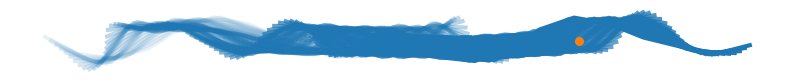

In [ ]:
print("Optimization results:")
print("Displacement to target: ", g_opt[-1, 4:] - gt[4:])
print_quaternion(torch.tensor(g[-1, :4]))
print_quaternion(torch.tensor(g_opt[-1, :4]))
print_quaternion(torch.tensor(gt[:4]))

alphas = np.linspace(0.1, 1.0, n_ts)
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 1)
ax_tmp = fig.add_subplot(gs[0, 0])
for id_step in range(n_ts):
    ax_tmp.plot(pos_opt[id_step, :, 0], pos_opt[id_step, :, 1], lw=3.0, c='tab:blue', alpha=alphas[id_step], zorder=0)
    ax_tmp.scatter(g_opt[id_step, 4], g_opt[id_step, 5], marker='x', s=30.0, c='tab:blue', alpha=alphas[id_step], zorder=0)

ax_tmp.scatter(gt[4], gt[5], marker='o', s=30.0, c='tab:orange', alpha=1.0, zorder=1)
ax_tmp.set_aspect('equal')
plt.axis('off')
plt.show()
